In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 01 - Data preprocessing and merging
# 1. Load the raw CSVs from Olist dataset
orders = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')

# 2. Merge all the tables step by step using 'left' joins
# This ensures we keep all rows from the orders table
df = orders.merge(customers, on='customer_id', how='left')
df = df.merge(order_items, on='order_id', how='left')
df = df.merge(products, on='product_id', how='left')
df = df.merge(sellers, on='seller_id', how='left')

# 3. Check and print missing values
missing = df.isnull().sum()
missing = missing[missing > 0]
if not missing.empty:
    print("⚠️ Missing values detected:")
    print(missing)
else:
    print("✅ No missing values detected.")

# 4. Check and remove duplicate rows
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"⚠️ Found {duplicates} duplicate rows. Dropping them...")
    df = df.drop_duplicates()
else:
    print("✅ No duplicate rows found.")

# 5. Convert date columns to datetime format (with error handling)
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'], errors='coerce')
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'], errors='coerce')
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], errors='coerce')

# 6. Drop rows with missing values in essential columns
required_columns = [
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'order_purchase_timestamp',
    'product_weight_g',
    'product_category_name',
    'customer_state'
]
df = df.dropna(subset=required_columns)

# 7. Keep only rows where order was delivered
df = df[df['order_status'] == 'delivered']

# 8. Feature engineering
# Create 'shipping_days' = estimated delivery time in days
df['shipping_days'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.days

# Create binary target 'delay' = 1 if delivered late, else 0
df['delay'] = (df['order_delivered_customer_date'] > df['order_estimated_delivery_date']).astype(int)

# 9. Encode categorical variables
df['customer_state_encoded'] = df['customer_state'].astype('category').cat.codes
df['product_category_encoded'] = df['product_category_name'].astype('category').cat.codes

# 10. Select final columns for modeling
final_df = df[[
    'order_id',
    'shipping_days',
    'delay',
    'product_weight_g',
    'customer_state_encoded',
    'product_category_encoded'
]]

# 11. Export cleaned dataset to CSV
final_df.to_csv('Olist_Simplified_Cleaned_Dataset.csv', index=False)
print("✅ Final dataset saved as 'Olist_Simplified_Cleaned_Dataset.csv'")

⚠️ Missing values detected:
order_approved_at                 161
order_delivered_carrier_date     1968
order_delivered_customer_date    3229
order_item_id                     775
product_id                        775
seller_id                         775
shipping_limit_date               775
price                             775
freight_value                     775
product_category_name            2378
product_name_lenght              2378
product_description_lenght       2378
product_photos_qty               2378
product_weight_g                  793
product_length_cm                 793
product_height_cm                 793
product_width_cm                  793
seller_zip_code_prefix            775
seller_city                       775
seller_state                      775
dtype: int64
✅ No duplicate rows found.
✅ Final dataset saved as 'Olist_Simplified_Cleaned_Dataset.csv'


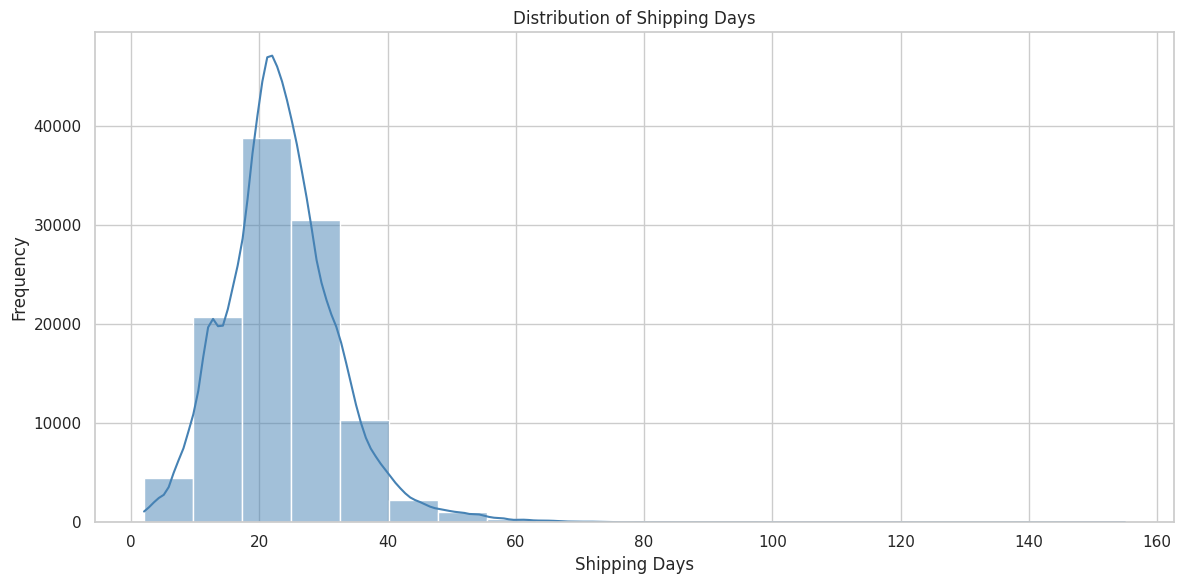

<ipython-input-16-71ad726574e9>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_delay.index.astype(str), y=category_delay.values, palette=palette)


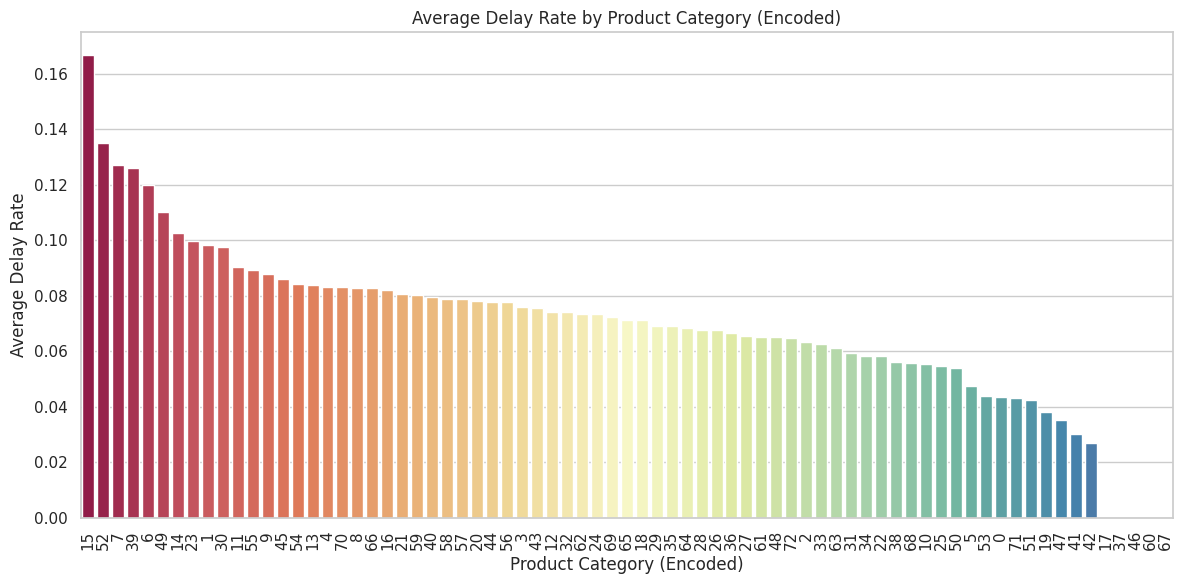

<ipython-input-16-71ad726574e9>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_delay.index.astype(str), y=state_delay.values, palette=palette)


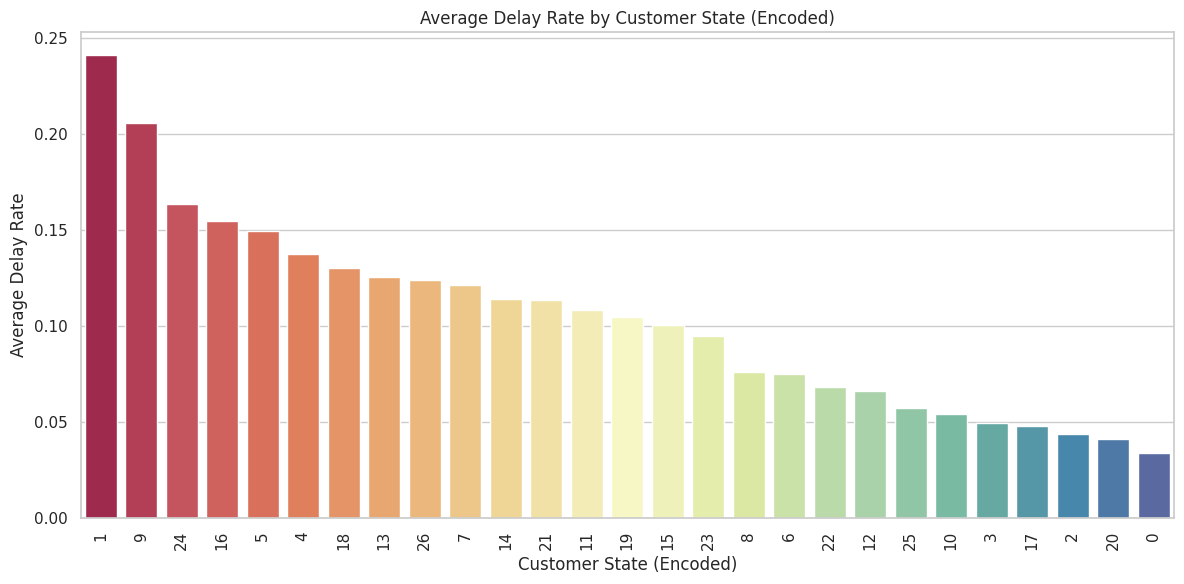

<ipython-input-16-71ad726574e9>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='delay', y='shipping_days', data=filtered_df, palette='Set2')


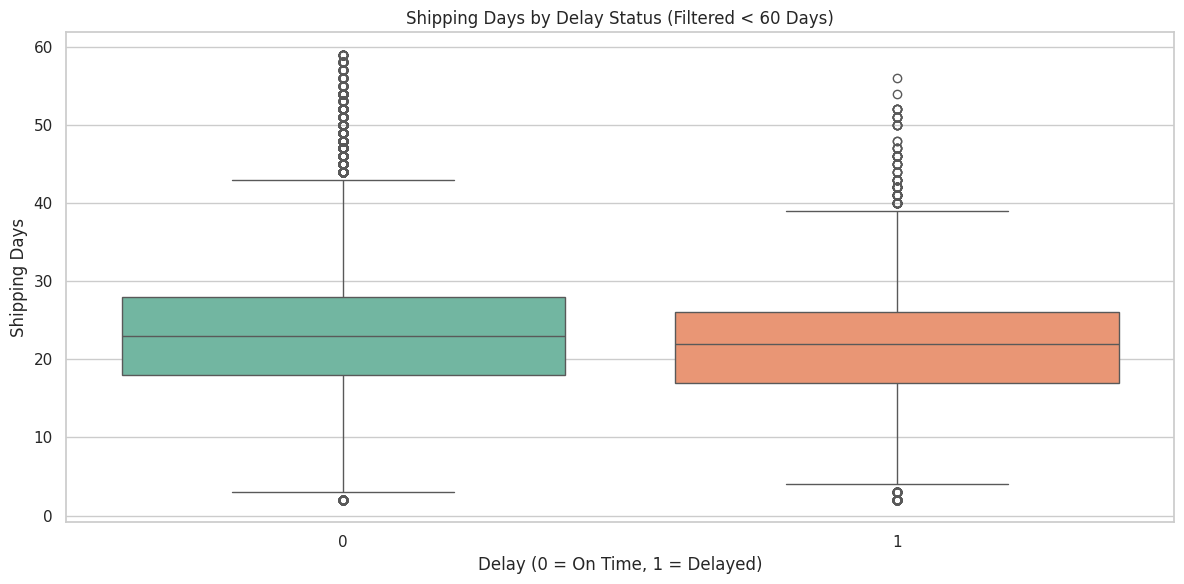

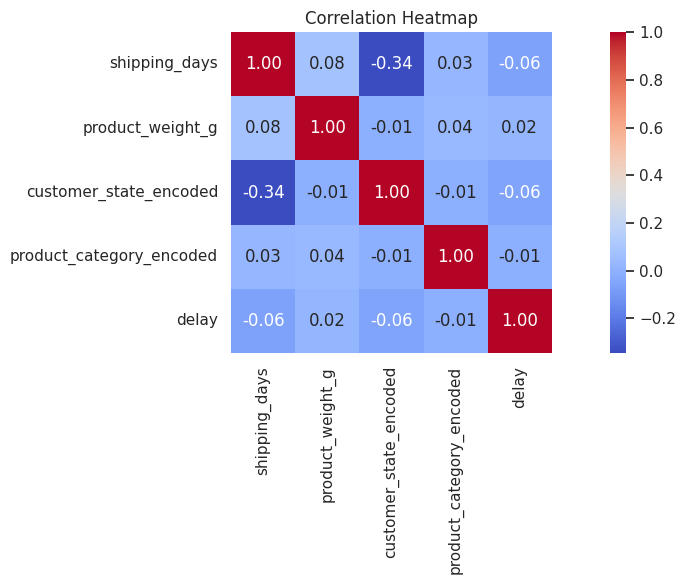

In [16]:
# 02 - EDA: Olist Shipping Delay Project
# This Section Exploratory Data Analysis (EDA) on the cleaned Olist dataset.

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
os.makedirs('eda_outputs', exist_ok=True)

# 1. Histogram: Shipping Days Distribution
plt.figure()
sns.histplot(df['shipping_days'], bins=20, kde=True, color='steelblue')
plt.title('Distribution of Shipping Days')
plt.xlabel('Shipping Days')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 2. Bar Plot: Delay Rate by Product Category (Encoded) with Color Gradient
plt.figure()
category_delay = df.groupby('product_category_encoded')['delay'].mean().sort_values(ascending=False)
palette = sns.color_palette("Spectral", n_colors=len(category_delay))
sns.barplot(x=category_delay.index.astype(str), y=category_delay.values, palette=palette)
plt.title('Average Delay Rate by Product Category (Encoded)')
plt.xlabel('Product Category (Encoded)')
plt.ylabel('Average Delay Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 3. Bar Plot: Delay Rate by Customer State (Encoded) with Color Gradient
plt.figure()
state_delay = df.groupby('customer_state_encoded')['delay'].mean().sort_values(ascending=False)
palette = sns.color_palette("Spectral", n_colors=len(state_delay))
sns.barplot(x=state_delay.index.astype(str), y=state_delay.values, palette=palette)
plt.title('Average Delay Rate by Customer State (Encoded)')
plt.xlabel('Customer State (Encoded)')
plt.ylabel('Average Delay Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 4. Boxplot: Shipping Days by Delay Status with color
plt.figure()
filtered_df = df[df['shipping_days'] < 60]
sns.boxplot(x='delay', y='shipping_days', data=filtered_df, palette='Set2')
plt.title('Shipping Days by Delay Status (Filtered < 60 Days)')
plt.xlabel('Delay (0 = On Time, 1 = Delayed)')
plt.ylabel('Shipping Days')
plt.tight_layout()
plt.show()

# 5. Correlation Heatmap
plt.figure()
corr = df[['shipping_days', 'product_weight_g', 'customer_state_encoded', 'product_category_encoded', 'delay']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()



🔍 Individual Model Reports:

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72     20013
           1       0.10      0.57      0.18      1718

    accuracy                           0.58     21731
   macro avg       0.52      0.57      0.45     21731
weighted avg       0.87      0.58      0.67     21731


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91     20013
           1       0.19      0.29      0.23      1718

    accuracy                           0.84     21731
   macro avg       0.56      0.59      0.57     21731
weighted avg       0.88      0.84      0.86     21731


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     20013
           1       0.24      0.22      0.23      1718

    accuracy                     

<ipython-input-17-653225339cfd>:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='Set2')


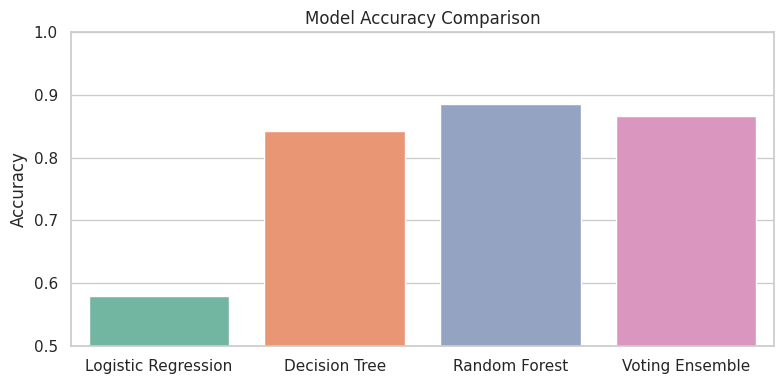

💾 Saved best model as 'voting_ensemble_model.pkl'


In [17]:
# 03 - Model Training with Ensemble and Balanced Classes

# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Define features (X) and target variable (y)
X = df[['shipping_days', 'product_weight_g', 'customer_state_encoded', 'product_category_encoded']]
y = df['delay']  # Target: 1 = delayed, 0 = on time

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define individual models with balanced class weights to handle class imbalance
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
dec_tree = DecisionTreeClassifier(class_weight='balanced')
rand_forest = RandomForestClassifier(class_weight='balanced')

# Dictionary to store models and results
models = {
    'Logistic Regression': log_reg,
    'Decision Tree': dec_tree,
    'Random Forest': rand_forest
}

results = {}

# Train and evaluate each individual model
print("\n🔍 Individual Model Reports:")
for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Predict on test set
    # Evaluate using classification report, suppressing division warnings
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    results[name] = report['accuracy']  # Store accuracy
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

# Create a VotingClassifier ensemble using the trained models
ensemble_model = VotingClassifier(estimators=[
    ('lr', log_reg),
    ('dt', dec_tree),
    ('rf', rand_forest)
], voting='hard')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Predict and evaluate ensemble performance
y_pred_ensemble = ensemble_model.predict(X_test)
ensemble_report = classification_report(y_test, y_pred_ensemble, output_dict=True, zero_division=0)
results['Voting Ensemble'] = ensemble_report['accuracy']  # Add ensemble accuracy

# Print ensemble report
print("\n✅ Voting Ensemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble, zero_division=0))

# Plot accuracy comparison of all models
plt.figure(figsize=(8, 4))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='Set2')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.show()

# Save the ensemble model for use in deployment (e.g., Streamlit app)
joblib.dump(ensemble_model, 'voting_ensemble_model.pkl')
print("💾 Saved best model as 'voting_ensemble_model.pkl'")
